In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical

In [3]:
def preprocessing(train, split_train_size = 1/7):

    X_train = train.drop(["label"],
                         axis = 1)
    y_train = train["label"]

    
    X_train = X_train.values.reshape(-1,28,28)

    
    y_train = to_categorical(y_train, num_classes = 10)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = split_train_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [4]:
def load_data(from_MNIST = True):
    

    
    if from_MNIST:
    
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
   
    
    
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    nb_images_train = x_train.shape[0]

    x_train = x_train.reshape(nb_images_train, 784)
    return (x_train, y_train, x_test, y_test)

In [5]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [6]:
def create_generator():
    

    
    generator=Sequential()
    generator.add(Dense(units=256, input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss = 'binary_crossentropy', 
                      optimizer = adam_optimizer())
    return generator

g = create_generator()
g.summary()
plot_model(g, show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

In [7]:
def create_discriminator():
    

    
    discriminator = Sequential()
    discriminator.add(Dense(units = 1024, input_dim = 784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units = 512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss = 'binary_crossentropy', 
                          optimizer = adam_optimizer())
    return discriminator

d = create_discriminator()
d.summary()
plot_model(d, show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [8]:
def create_gan(discriminator, generator):
    

    discriminator.trainable=False

    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    
    gan = Model(inputs = gan_input, outputs = gan_output)
    
    gan.compile(loss = 'binary_crossentropy', 
                optimizer = 'adam')
    return gan

gan = create_gan(d,g)
gan.summary()
plot_model(gan, show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1486352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2946577 (11.24 MB)
Trainable params: 1486352 (5.67 MB)
Non-trainable params: 1460225 (5.57 MB)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], 
                   interpolation = 'nearest', 
                   cmap = 'gray')
        plt.axis('off')
    plt.tight_layout()

4/4 [==============================] - 0s 2ms/step


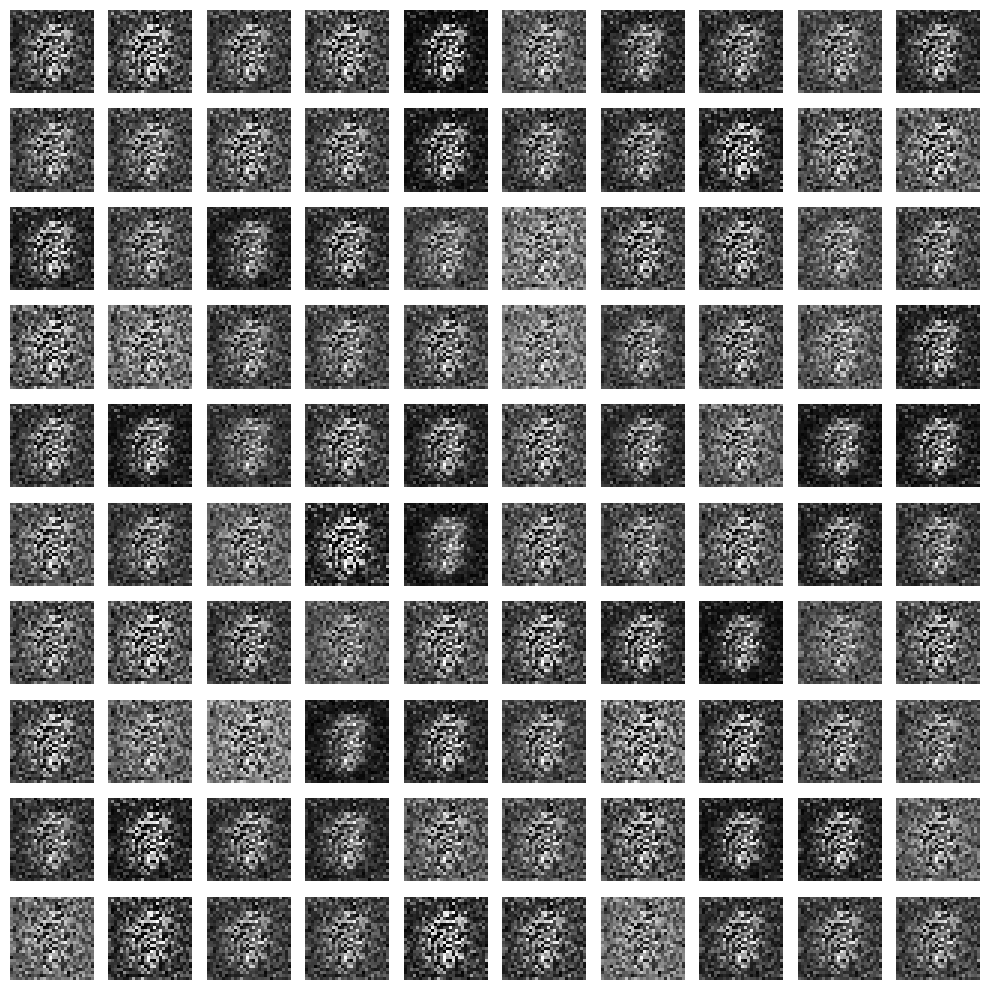

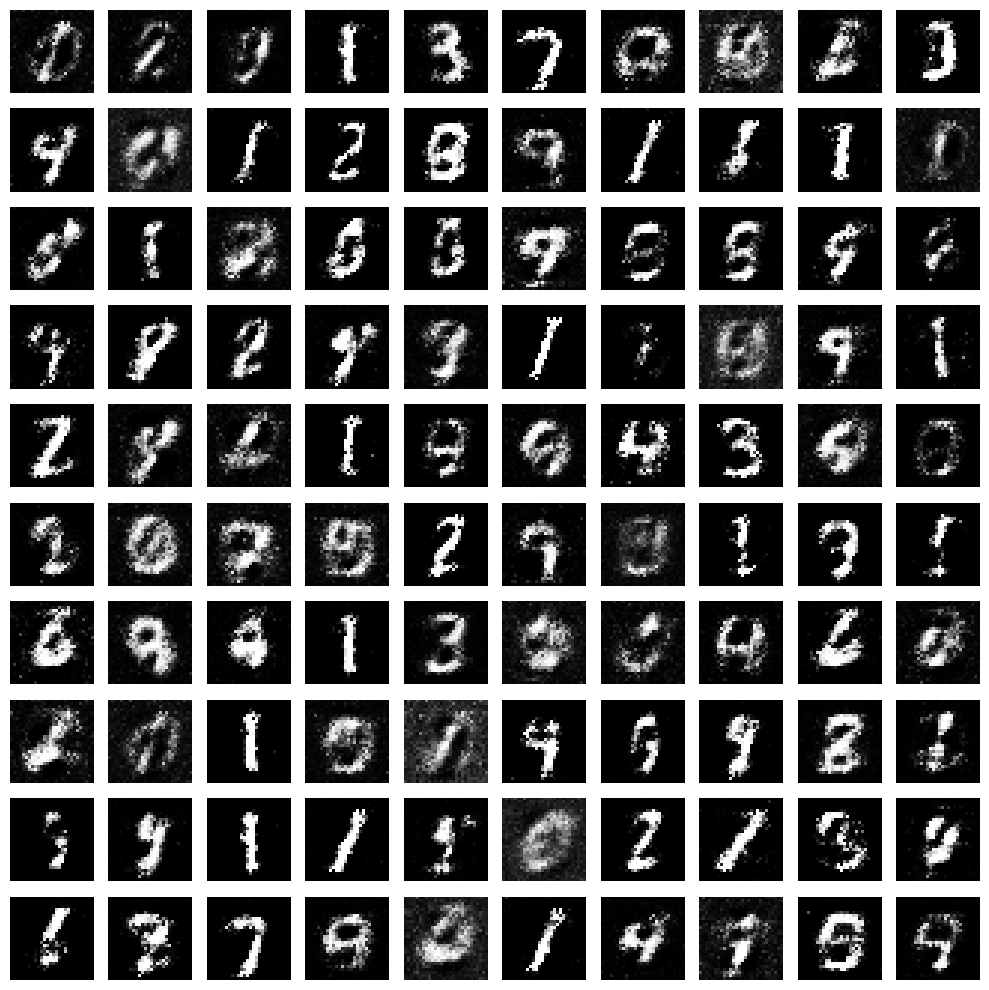

In [15]:
def training(epochs=1, batch_size=128):
    
    
    (X_train, y_train, X_test, y_test) = load_data(from_MNIST = True)
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        
        for _ in range(batch_size):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            

            discriminator.trainable=False
            

            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)

training(20,128)